#### identifying nodules using trained network

In [1]:
import numpy as np
import cv2
import time
from glob import glob
import os
import matplotlib.pylab as plt
from sklearn.externals import joblib
from skimage import measure
from skimage.transform import resize
import ntpath
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#p = sns.color_palette()
from skimage.draw import circle
#import re
#import traceback
import dicom
import h5py
import random

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy','pandas')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1
pandas: 0.19.2


## settings

In [26]:
path2nodes="/media/mra/My Passport/Kaggle/datascience2017/hpz440/LUNA2016/hdf5/nodes/"

path2logs='./output/logs/'

# original data dimension
H,W=512,512

# trained data dimesnsion
h,w=256,256

# seed point
seed = 2016
seed = np.random.randint(seed)


## utils

In [144]:

# preprocess
def preprocess(X,Y,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    if Y is None:
        Y=np.zeros_like(X,dtype='uint8')
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    output=param_prep['output'] # output
    
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hcr:H-hcr,wcr:W-wcr]
        Y=Y[:,:,hcr:H-hcr,wcr:W-wcr]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        Y_r=np.zeros([N,C,h,w],dtype='uint8')
        for k1 in range(X.shape[0]):
            X_r[k1] = cv2.resize(X[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
            Y_r[k1] = cv2.resize(Y[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)>0.5 # binary mask 
    else:
        X_r=X
        Y_r=Y
    
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
    elif norm_type is 'minmax_bound':        
        # normalization
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0
        X_r = (X_r - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        X_r[X_r>1] = 1.
        X_r[X_r<0] = 0.

    # center coordinates and diameter
    y_r=mask2coord(Y_r)            
    
    if output is 'mask':    
        return X_r,Y_r
    elif output is 'coords':
        return X_r,y_r

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def disp_img_2masks(img,mask1,mask2,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        # random indices   
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=indices
    
    I1=img[n1,0]
    #M1=mask1[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask1.shape[1]):
        M1=np.logical_or(M1,mask1[n1,c1,:])    
    #M2=mask2[n1,0]
    M2=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask2.shape[1]):
        M2=np.logical_or(M2,mask2[n1,c1,:])    
    
    C1=(0,255,9)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    plt.show()            
    return n1        




def array_stats(X):
    X=np.asarray(X)
    
    # get var name
    #stack = traceback.extract_stack()
    #filename, lineno, function_name, code = stack[-2]
    #vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    
    #print (vars_name,X.shape, X.dtype)
    print ('array shape',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
    print '-'*50

# convert mask to coordinates
def mask2coord(Y):
    N,C,H,W=Y.shape
    coords=np.zeros((N,3))
    for k in range(N):
        region=measure.regionprops(Y[k,0])
        if len(region)>0:
            (x,y),radius = cv2.minEnclosingCircle(region[0].coords)
            coords[k,:]=[x,y,radius]
    R=100
    #print np.max(coords[:,2])
    coords=coords/[H,W,R]
    coords=coords[:,:nb_output]
    return coords

# convert coordinates to mask
def coord2mask(y_pred,params):
    h,w,R=params
    n=len(y_pred)
    Y_pred=np.zeros((n,1,h,w),dtype='uint8')
    for k1 in range(n):
        img = np.zeros((h, w), dtype=np.uint8)
        r,c,radius=y_pred[k1,:]*[h,w,R]
        rr, cc = circle(r,c,radius)
        img[rr, cc] = 1
        Y_pred[k1,:]=img
    return Y_pred    


#scan=load_scan(path2dicom+p_id)
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
       
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    #image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# extract three consecutive images from BS subject
def extract_dsb(trn_nc,bs,df_train):
    # pick bs random subjects
    rnd_nc_inds=random.sample(trn_nc,bs)    
    
    # read h5 file
    f2=h5py.File(path2dsb,'r')
    
    # initialize    
    X=np.zeros((bs,3,H,W),'int16')
    y=np.zeros(bs,dtype='uint8')
    for k,ind in enumerate(rnd_nc_inds):
        p_id=df_train.id[ind]
        #print p_id
    
        X0=f2[p_id]
    
        # pick three concecutive slices
        n1=np.random.randint(len(X0)-3)
        #print n1
        X0=X0[n1:n1+3]
        #array_stats(X0) 
        X[k,:]=X0
    
    f2.close()    
    return X,y

def crop_nodule_roi(X,Y1,Y2,y):
    if Y1 is None:
        Y1=np.zeros_like(X,dtype='uint8')
    if Y2 is None:        
        Y2=np.zeros_like(X,dtype='uint8')
    
    N,C0,H0,W0=X.shape
    hc,wc=128,128
    
    Xc=np.zeros((N,C0,hc,wc))
    Yc1=np.zeros((N,C0,hc,wc),dtype='uint8')
    Yc2=np.zeros((N,C0,hc,wc),dtype='uint8')
    for k in range(N):
        r,c,_=y[k,:]*[H0,W0,100]
        #print r,c
        if r>=hc/2 and (r+hc/2)<=H0:
            r1=int(r-hc/2)
            r2=int(r+hc/2)        
        elif r<hc/2:
            r1=0
            r2=int(r1+hc)
        elif (r+hc/2)>H:
            r2=H0
            r1=r2-hc
            

        if c>=wc/2 and (c+wc/2)<=W0:
            c1=int(c-wc/2)
            c2=int(c+wc/2)        
        elif c<wc/2:
            c1=0
            c2=int(c1+wc)
        elif (c+wc/2)>W:
            c2=W0
            c1=c2-wc
            
            
        #print k,c2-c1,r2-r1,r2,c2,X.shape
        Xc[k,:]=X[k,:,r1:r2,c1:c2]
        Yc1[k,:]=Y1[k,:,r1:r2,c1:c2]
        Yc2[k,:]=Y2[k,:,r1:r2,c1:c2]
    return Xc,Yc1,Yc2        


def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

####### normalization
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

### load nodes

total subjects: 1397


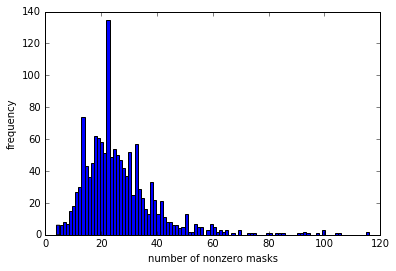

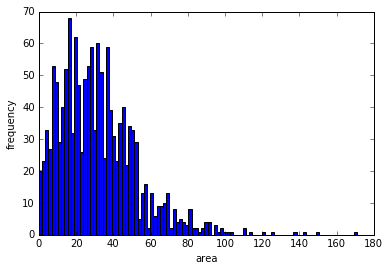

[u'Y', u'cnz', u'nzYi', u'sYi']


In [41]:

# fold number
foldnm=0

# data path
path2dsbnodes=path2nodes+'fold'+str(foldnm)+'_dsb_nodes.hdf5'
path2dsbtestnodes=path2nodes+'fold'+str(foldnm)+'_dsbtest_nodes.hdf5'

# load test data
ff1=h5py.File(path2dsbnodes)
print 'total subjects: %s' %(len(ff1.keys()))

maxAi=[]
cnz=[]
for id in ff1.keys():
    cnz.append(ff1[id]['cnz'].value)
    maxai=ff1[id]['sYi'][0]
    maxAi.append(maxai)
    
   
plt.hist(cnz,100)    
plt.title('')
plt.xlabel('number of nonzero masks')
plt.ylabel('frequency')
plt.show() 

plt.hist(maxAi,100)    
plt.title('')
plt.xlabel('area')
plt.ylabel('frequency')
plt.show() 


print ff1[ff1.keys()[0]].keys()

(56, 1, 256, 256)


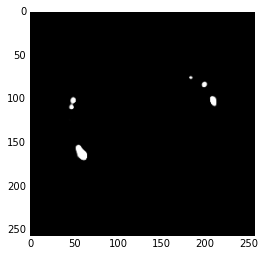

In [45]:
Y=ff1[id]['Y']
print Y.shape
plt.imshow(Y[maxAi[-1],0],cmap='gray')
plt.show()

fold: 0
total subjects: 1397
fold: 1
total subjects: 1397
fold: 2
total subjects: 1397
fold: 3
total subjects: 1397
fold: 4
total subjects: 1397
fold: 5
total subjects: 1397
fold: 6
total subjects: 1397
fold: 7
total subjects: 1397
fold: 8
total subjects: 1397
fold: 9
total subjects: 1397


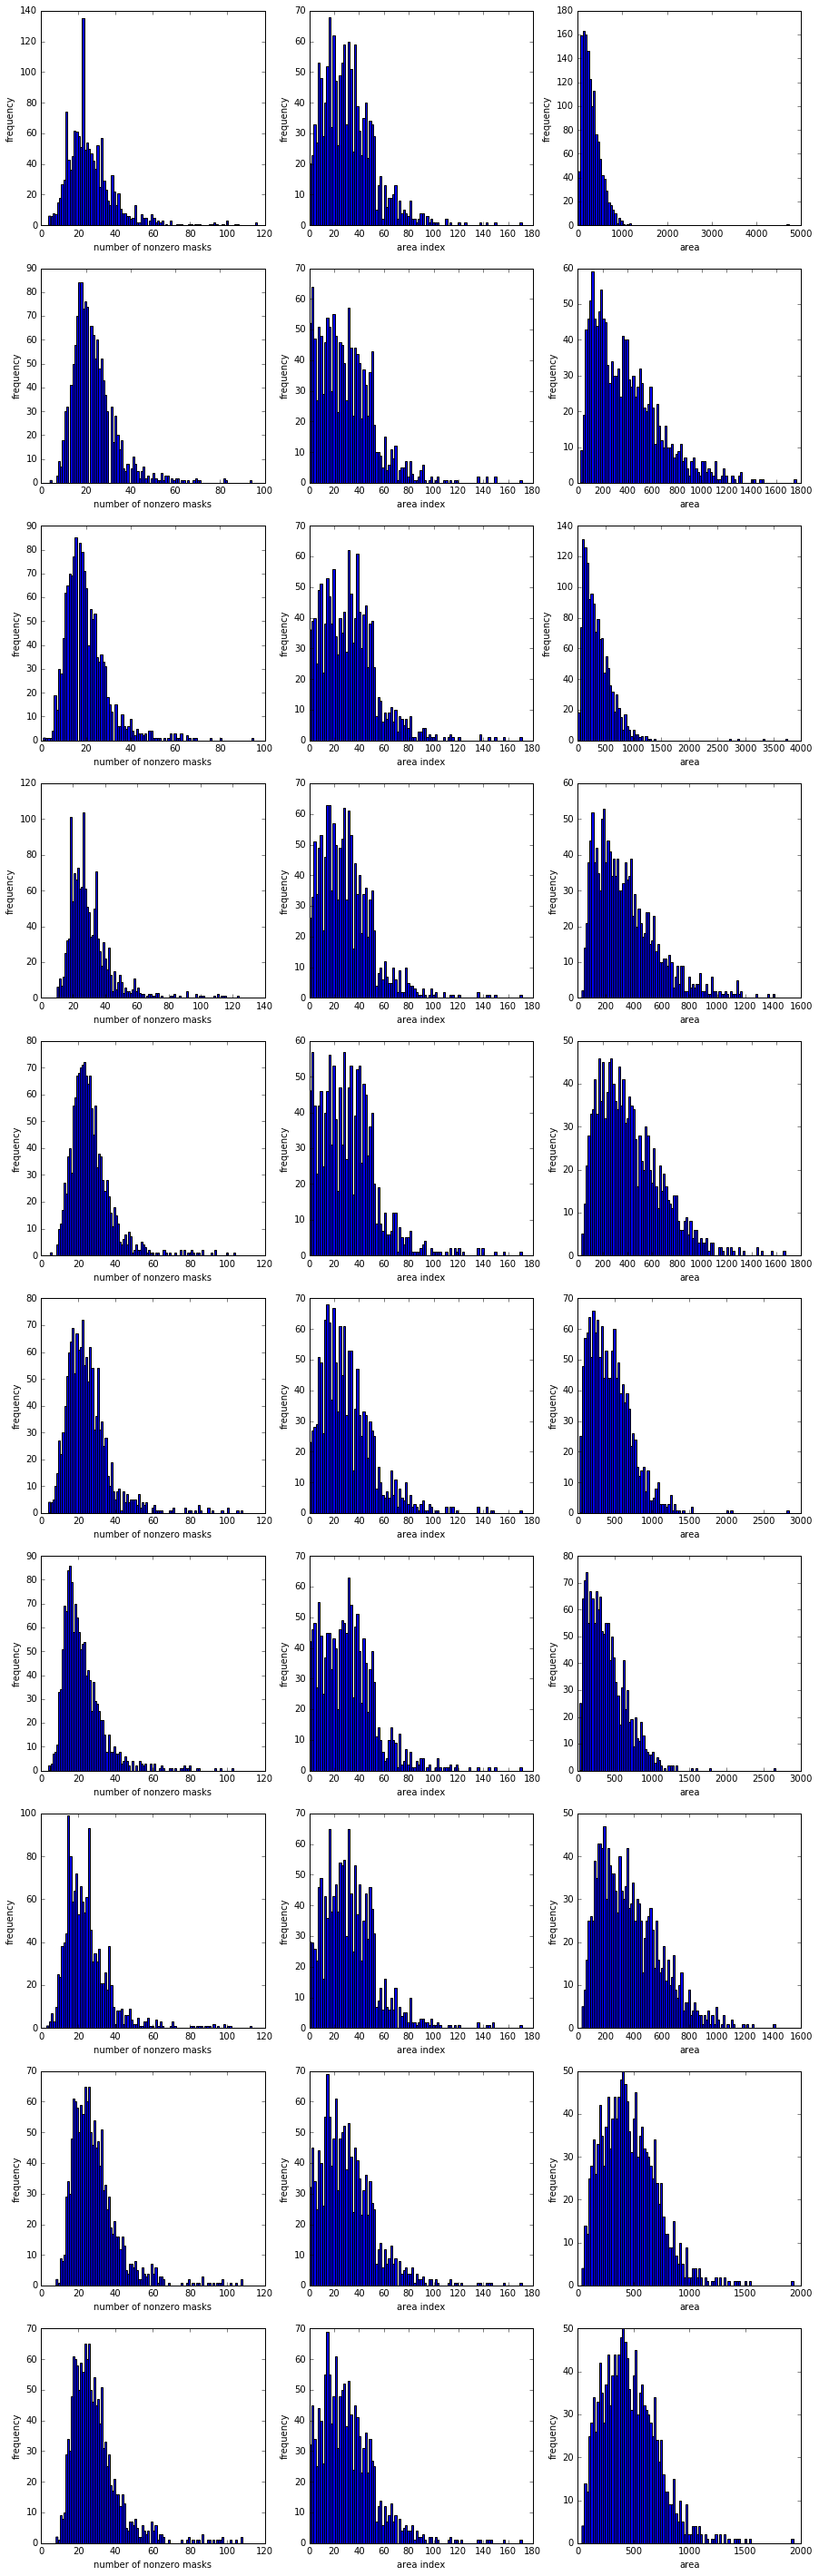

In [62]:
foldnms=[0,1,2,3,4,5,6,7,8,9]

k=0
plt.figure(figsize=(15,50))

# fold number
for foldnm in foldnms:
    print 'fold: %s' %foldnm

    # data path
    path2dsbnodes=path2nodes+'fold'+str(foldnm)+'_dsb_nodes.hdf5'
    path2dsbtestnodes=path2nodes+'fold'+str(foldnm)+'_dsbtest_nodes.hdf5'

    # load test data
    ff1=h5py.File(path2dsbnodes)
    print 'total subjects: %s' %(len(ff1.keys()))

    maxAi=[]
    maxA=[]
    cnz=[]
    for id in ff1.keys():
        cnz.append(ff1[id]['cnz'].value)
        maxai=ff1[id]['sYi'][0]
        maxAi.append(maxai)
        maxA.append(np.sum(ff1[id]['Y'][maxai,0]))
    r=10    
    plt.subplot(r,3,3*k+1)
    plt.hist(cnz,100)    
    plt.title('')
    plt.xlabel('number of nonzero masks')
    plt.ylabel('frequency')
    #plt.show() 

    plt.subplot(r,3,3*k+2)    
    plt.hist(maxAi,100)    
    plt.title('')
    plt.xlabel('area index')
    plt.ylabel('frequency')

    plt.subplot(r,3,3*k+3)    
    plt.hist(maxA,100)    
    plt.title('')
    plt.xlabel('area')
    plt.ylabel('frequency')
    
    k=k+1    
plt.show()     

## load results from the ensemble models

wait ...
total subjects: 1397
0015ceb851d7251b8f399e39779d1e7d 276.910100859
0030a160d58723ff36d73f41b170ec21 196.142089192
003f41c78e6acfa92430a057ac0b306e 304.028091431
006b96310a37b36cccb2ab48d10b49a3 266.661675
008464bb8521d09a42985dd8add3d0d2 138.913630693
0092c13f9e00a3717fdc940641f00015 204.614257812
00986bebc45e12038ef0ce3e9962b51a 12.1498196777
00cba091fa4ad62cc3200a657aeb957e 96.7992201651
00edff4f51a893d80dae2d42a7f45ad1 97.6194973206
0121c2845f2b7df060945b072b2515d7 22.9309082031
013395589c01aa01f8df81d80fb0e2b8 104.143619537
01de8323fa065a8963533c4a86f2f6c1 64.4430841985
01e349d34c06410e1da273add27be25c 337.789916992
01f1140c8e951e2a921b61c9a7e782c2 186.877441406
024efb7a1e67dc820eb61cbdaa090166 122.561141968
0257df465d9e4150adef13303433ff1e 346.9312
0268f3a7a17412178cfb039e71799a80 228.426780039
026be5d5e652b6a7488669d884ebe297 24.3759571289
02801e3bbcc6966cb115a962012c35df 204.322182
028996723faa7840bb57f57e28275e4c 207.70111084
0334c8242ce7ee1a6c1263096e4cc535 170.32228

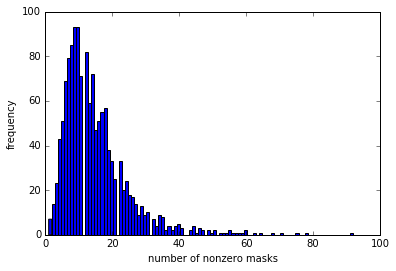

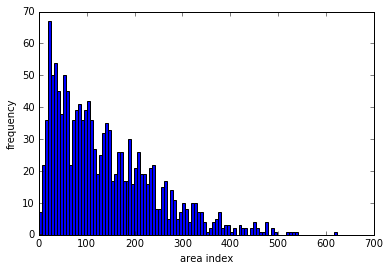

[u'Y', u'cnz', u'nzYi', u'sYi']


In [93]:
print 'wait ...'

# data path
path2dsbnodes=path2nodes+'nfolds'+'_dsb_nodes.hdf5'
path2dsbtestnodes=path2nodes+'nfolds'+'_dsbtest_nodes.hdf5'

# spacing file
path2spacing='/media/mra/win71/data/misc/kaggle/datascience2017/data/dsb_spacing.hdf5'
ff_spacing=h5py.File(path2spacing,'r')

# load test data
ff1=h5py.File(path2dsbnodes)
print 'total subjects: %s' %(len(ff1.keys()))

maxAi=[]
cnz=[]
maxA=[]
for id in ff1.keys():
    spacing=ff_spacing[id].value
    cnz.append(ff1[id]['cnz'].value)
    maxai=ff1[id]['sYi'][0]
    maxAi.append(maxai)
    Y=ff1[id]['Y']
    maxA.append(np.sum(Y[maxai,0]>.5)*(spacing[0]*spacing[1]))
    print id,maxA[-1]
   
plt.hist(cnz,100)    
plt.title('')
plt.xlabel('number of nonzero masks')
plt.ylabel('frequency')
plt.show() 

plt.hist(maxA,100)    
plt.title('')
plt.xlabel('area index')
plt.ylabel('frequency')
plt.show() 


print ff1[ff1.keys()[0]].keys()

0334c8242ce7ee1a6c1263096e4cc535
(47, 1, 256, 256)
[ 0.644531  0.644531]
19.5247498682
14.9551275586
12.4626062988
10.385505249
10.385505249
7.89298398926
[6, 39, 14, 30, 40, 8]


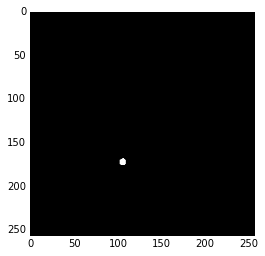

In [139]:
id=ff1.keys()[20]
print id

Y=np.array(ff1[id]['Y'])>.5
print Y.shape

spacing=ff_spacing[id].value
print spacing

sumY=np.sum(Y,axis=(1,2,3))*spacing[0]*spacing[1]*4
sY_sorti=np.argsort(-sumY)

# pick areas within 5mm to 30 mm
sYp_sort=[]
for ind in sY_sorti:
    if sumY[ind]>=5 and sumY[ind]<=30:         
        print sumY[ind]
        sYp_sort.append(ind)
print sYp_sort

plt.imshow(Y[sYp_sort[0],0],cmap='gray')
plt.show()

spacing: [ 0.625  0.625]
id: 95a27273c11db8bfb9fc27b1e64de6bd 1
mm [16, 7, 30, 20, 34, 23, 19, 12, 13, 28, 32, 31, 6, 17, 35, 24, 11, 5, 8, 18, 41, 4, 33, 26, 22, 40, 29]
pixel [ 9 10 14 15 16  7 30 20 34 23 19 12 13 28 32 31  6 17 35 24 11  5  8 18 41
  4 33 26 22 40 29 38 25 36 27 39 42  0 43 21  3  2  1 37 44]


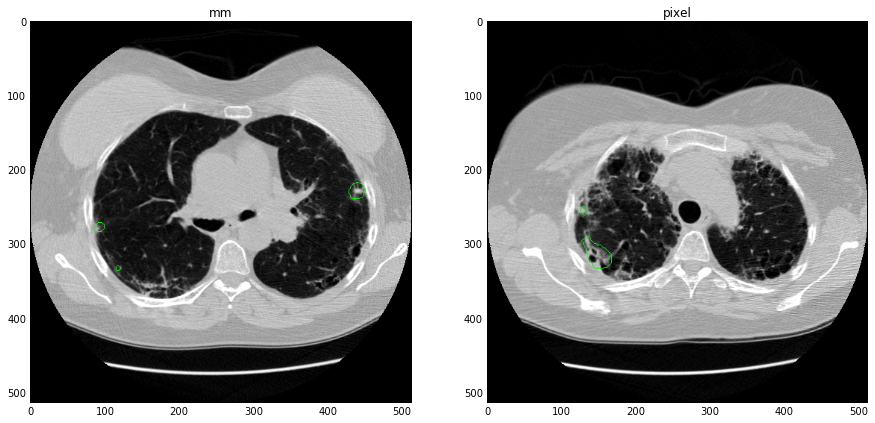

In [352]:
root_data='/media/mra/win71/data/misc/kaggle/datascience2017/data/'
path2dsb=root_data+'dsb.hdf5'
path2dsbtest=root_data+'dsbtest.hdf5'

path2csv=root_data+'stage1_labels.csv'
path2logs='./output/logs/'

rnd_id=np.random.randint(1397)
id=ff1.keys()[rnd_id]


# spacing
spacing=ff_spacing[id].value
print 'spacing:', spacing

# read dsb data
f2=h5py.File(path2dsb,'r')
X=f2[id]
y=f2[id].attrs['cancer']
print 'id: %s %s' %(id,y)

# read nodes
Y=np.array(ff1[id]['Y'])>.5                    

# find areas
sumY=np.sum(Y,axis=(1,2,3))*spacing[0]*spacing[1]
sY_sorti=np.argsort(-sumY)

# pick areas within 5mm to 30 mm
sYp_sort=[]
for ind in sY_sorti:
    if sumY[ind]>=5 and sumY[ind]<=60:         
        #print sumY[ind]
        sYp_sort.append(ind)
print 'mm',sYp_sort
print 'pixel',sY_sorti

# pick max area, im mm
nx1=sYp_sort[0]*3+3
ny1=sYp_sort[0]
X1=normalize(X[nx1])

Y1=np.array(Y[ny1,0]>.5,'uint8')                         
Y1= cv2.resize(Y1, (W, H), interpolation=cv2.INTER_CUBIC)

# max area pixeld based
nx2=sY_sorti[0]*3+3
ny2=sY_sorti[0]
X2=normalize(X[nx2])

Y2=np.array(Y[ny2,0]>.5,'uint8')                         
Y2= cv2.resize(Y2, (W, H), interpolation=cv2.INTER_CUBIC)



plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
imgmask=image_with_mask(X1,Y1)
plt.imshow(imgmask)
plt.title('mm')

plt.subplot(1,2,2)
imgmask=image_with_mask(X2,Y2)
plt.imshow(imgmask)
plt.title('pixel')
plt.show()
